In [5]:
import pydicom
from pydicom.data import get_testdata_file
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import scipy
from scipy.signal import find_peaks

#Create dicom for PVDR calc
source1=np.zeros((757,750,593)).astype(np.float32)
for i in np.arange(1,6):
    ds = pydicom.dcmread("d:/Desktop/SFRT-Topas/vhee/vhee_patient/shaped_beam/results/dosetomedium_vhee_shapedbeam_250MV_1M_90deg__"+str(i)+".dcm")
    source1=np.add(source1,ds.pixel_array*ds.DoseGridScaling).astype(np.float32)
source1=source1/1.6021766e-19/5e6
tot_dcm=source1

In [8]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

(757, 750, 593)
707 458
39.0 mm


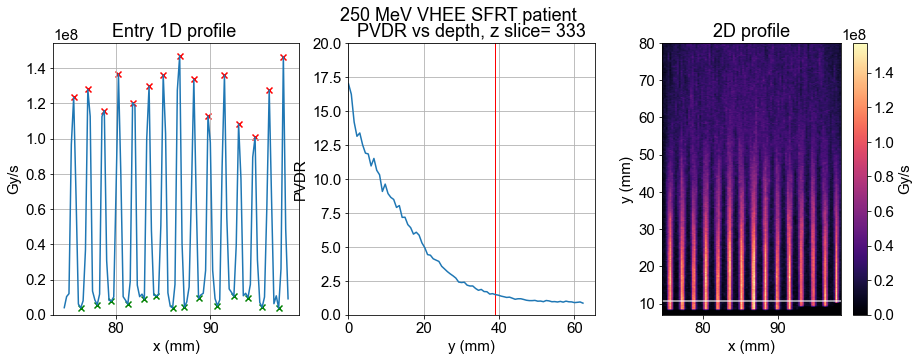

In [9]:
print(np.shape(tot_dcm))

yentry=707
maxdose=23e7
leftedge=298
rightedge=394
y= np.arange(0,yentry)*0.25
x= np.arange(leftedge,rightedge)*0.25
zslice=333



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
im1=ax3.imshow(tot_dcm[zslice],aspect=0.5,extent=(0,593*0.25,0,750*0.25),cmap='magma')
ax3.set_ylabel('y (mm)')
ax3.set_xlabel('x (mm)')
ax3.set_ylim(7,80)
ax3.set_xlim(leftedge*0.25,rightedge*0.25)
fig.colorbar(im1,label='Gy/s')
fig.suptitle('250 MeV VHEE SFRT patient')
ax3.set_title('2D profile')
ax3.hlines((750-yentry)*0.25,0,500,colors='white',alpha=0.75)



ax1.plot(x,tot_dcm[zslice][yentry][leftedge:rightedge])
#ax1.set_ylim((0,maxdose))
ax1.set_ylabel('Gy/s')
ax1.set_xlabel('x (mm)')
ax1.grid()


peaks= find_peaks(tot_dcm[zslice][yentry][leftedge:rightedge],height=0.5e8,distance=4)[0]
valleys= find_peaks(-tot_dcm[zslice][yentry][leftedge:rightedge],distance=4)[0]
ax1.scatter(y[peaks+leftedge],tot_dcm[zslice][yentry][leftedge+peaks],marker='x',c='red')
ax1.scatter(y[valleys+leftedge],tot_dcm[zslice][yentry][leftedge+valleys],marker='x',c='green')
pvdr=np.mean(tot_dcm[zslice][yentry][leftedge+peaks])/np.mean(tot_dcm[zslice][yentry][leftedge+valleys])
ax1.set_title('Entry 1D profile ')
ax1.set_ylim(bottom=0)

pvdr_depth=[]
pvdr_error=[]
mean_peaks=[]
mean_valleys=[]
peak_error=[]
valley_error=[]
print(np.flip(np.arange(yentry-249,yentry+1))[0],np.flip(np.arange(yentry-249,yentry+1))[-1])
for j in np.flip(np.arange(yentry-249,yentry+1)):
    mean_peaks.append(np.mean(tot_dcm[zslice][j][leftedge+peaks]))
    mean_valleys.append(np.mean(tot_dcm[zslice][j][leftedge+valleys]))
pvdr_depth=[mean_peaks[k]/mean_valleys[k] for k in np.arange(0,len(mean_valleys))]
n=3
mean_peaks_avg=[sum(mean_peaks[k:k+n])/n for k in range(0,len(mean_peaks),n)]
mean_valleys_avg=[sum(mean_valleys[k:k+n])/n for k in range(0,len(mean_valleys),n)]
pvdr_depth_avg=[mean_peaks_avg[k]/mean_valleys_avg[k] for k in np.arange(0,len(mean_valleys_avg))]
y_avg=np.arange(0,len(pvdr_depth_avg))*0.25*n
ax2.plot(y_avg,pvdr_depth_avg)
ax2.grid()
ax2.set_title("PVDR vs depth, z slice= "+str(zslice))
ax2.set_ylabel('PVDR')
ax2.set_xlabel('y (mm)')
ax2.set_xlim(left=0)
ax2.set_ylim(0,20)
DOC= [w*0.25*n for w in np.arange(0,len(pvdr_depth_avg)) if np.max(pvdr_depth_avg[w:w+5])<=1.5][0]
print(str(DOC)+' mm')  
ax2.vlines(DOC,0,100,colors='red',lw=1)

In [ ]:
def align_y_axis(ax1, ax2, minresax1, minresax2,numticks):
    """ Sets tick marks of twinx axes to line up with x total tick marks

    ax1 and ax2 are matplotlib axes
    Spacing between tick marks will be a factor of minresax1 and minresax2"""

    ax1ylims = ax1.get_ybound()
    ax2ylims = ax2.get_ybound()
    ax1factor = minresax1 * (numticks-1)
    ax2factor = minresax2 * (numticks-1)
    ax1.set_yticks(np.linspace(ax1ylims[0],
                               ax1ylims[1]+(ax1factor -
                               (ax1ylims[1]-ax1ylims[0]) % ax1factor) %
                               ax1factor,
                               numticks))
    ax2.set_yticks(np.linspace(ax2ylims[0],
                               ax2ylims[1]+(ax2factor -
                               (ax2ylims[1]-ax2ylims[0]) % ax2factor) %
                               ax2factor,
                               numticks))

energy=np.arange(100,250+1,10)
DOC=[]
PVDR=[]
for i in energy:
    DOC.append(np.load('d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/DOC_PVDR'+str(i)+'.npy')[0])
    PVDR.append(np.load('d:/Desktop/SFRT-Topas/vhee/vhee_patient/depth_test/results/DOC_PVDR'+str(i)+'.npy')[1])

figure(1,figsize=(8,8))
fig, ax1=plt.subplots(figsize=(8,8))
plt.plot(energy,DOC,marker='o',label='Depth of convergence',markersize=9,c='tab:orange')
plt.ylabel('Depth of convergence (mm)',c='tab:orange')
plt.xlabel('Energy (MeV)')
plt.grid(c='lightgray',axis='both',ls='--')
plt.ylim(bottom=0)
ax2=ax1.twinx()
plt.plot(energy,PVDR,marker='o',markersize=9,label='PVDR')
plt.ylabel('PVDR',c='tab:blue')
plt.grid(c='lightgray',axis='both',ls='--')
plt.ylim(bottom=0)
fig.legend(loc="upper center", bbox_to_anchor=(0.5,0.8455))
plt.title('Depth test results (patient)')

align_y_axis(ax1,ax2,5,5,6)